## Installing dependencies

 - Have python3 running on your machine
 - Create a virtual environment `python3 -m venv venv` in your current working directory
 - Enter the virtual environment `source .venv/bin/activate`, run `pip install -r requirements.txt` to install all dependencies

----



In [64]:
import pandas as pd
import numpy as np
import matplot as mp
import random
import json
from collections import defaultdict
from collections import Counter
# 60 sec * 90 min = 5400 secs 
# 5400 / 30 (30s per tick)
simulation_tick = 180
teams = []

import matplotlib.pyplot as plt

## Question 1: Temperature Modeling

Consider a scenario where the temperature X(t) varies randomly over a continuous time interval t, where t is in the range from 0 to 1. We begin with the assumption that X(0) = 0, which means that the temperature at time 0 is 0. Now, if we choose a small time increment represented by ∆t, we can make the assumption that the change in temperature from time t to t + ∆t, denoted as X(t+ ∆t)− X(t), follows a normal distribution. This normal distribution is characterized by a mean of 0 and a variance of ∆t.

1. Let $P$ be the random variable denoting the proportion of time in [0, 1] such that the temperature is positive. Estimate the distribution of $P$ by Monte Carlo simulation and experimenting with various values of ∆t (e.g. ∆t = 0.01, 0.001, 0.0001, · · · .)
2. Let $T_{max}$ be the random variable denoting the time in [0, 1] such that the temperature is at its maximum. Estimate the distribution of $T_{max}$ by Monte Carlo simulation and experimenting with various values of ∆t (e.g. ∆t = 0.01, 0.001, 0.0001, · · · .)

# Question 2: Premier League Forecasting

Create a probabilistic model and perform Monte Carlo simulations to forecast the final points for Premier League teams in the 2024-2025 season. 

This model will include some unknown parameters that you will determine based on the data you gather. 

In Premier League matches, teams earn three points for a win, one point for a draw, and no points for a loss. For your predictions, you could use statistics from the beginning of the season up to a specific date to estimate the parameters of your model, and then run Monte Carlo simulations to project the outcomes of the remaining matches, ultimately predicting the final points for each team at the season's end. 

----

Here's a brief outline of a relatively straightforward way to model this scenario. 

For each match, you can treat the number of shots attempted by the home and away teams as random variables, such as Poisson random variables. The rate parameters of the Poisson distribution will be influenced by the strengths of both teams. Each shot taken will have an associated probability of scoring, which also varies depending on the teams involved. 

You are encouraged to create your own models, but it's essential to explain and justify your choices. Discuss how you determine the parameters and outline the advantages and limitations of the models you select.

-----
## Question 2: Premier League Forecasting:

The script datascraper.py extracts a large quantity of player statistics from the website https://www.fbref.com and returnst to us a *players.json* file that we can use for our predictive model.

The general principle of our simulation is a time based simulation. I.E we start the game off with a random player from the home team (excluding the gk) taking the kick-off. When it is taken he will pass to another random player (excluding the keeper). 

We then simulate the players chances of either passing, shooting, keeping or losing the ball accoring to the data collected and his position in the team. (For example, compared to a defender, a midfielder is more likely to pass the ball to a forward.) 

#### Team Lineup Creation Function:

In [45]:
#Creates an array of the team names!
with open("./teamFormations.json", 'r') as teamFile:
        teamsJSON = json.load(teamFile)
for team in teamsJSON:
    teams.append(team['name'])

In [46]:
class player:
    '''Player Class'''
    
    def __init__(self, name, url, pos, team, isGoalkeeper, mp, starts, gamesPlayedForCurrentTeam, startsForCurrentTeam, 
                 savePercentage, tacklesPG, interceptionsPG, shotsPG, passesPG, progPassesRecievedPG, progCarriesPG ):
        self.name = name
        self.url = url
        self.position = pos
        self.team = team
        self.isGoalkeeper = isGoalkeeper

        #Common stats:
        self.matchesPlayed = mp
        self.starts = starts
        self.gamesPlayedForCurrentTeam = gamesPlayedForCurrentTeam
        self.startsForCurrentTeam = startsForCurrentTeam

        # GK STATS:
        self.savePercentage = savePercentage

        # Outfielder Stats:
        self.tacklesPG = tacklesPG
        self.interceptionsPG = interceptionsPG
        self.shotsPG = shotsPG
        self.passesPG = passesPG
        self.progPassesRecievedPG = progPassesRecievedPG
        self.progCarriesPG = progCarriesPG
    
    def __str__(self):
        return f"[Name: {self.name}"

In [47]:

def predict_starting_lineup(team_name, iterations=10000, file_path="./players.json"):
    """
    Predict the starting lineup for a team using a Monte Carlo simulation.

    Parameters:
        file_path (str): Path to the JSON file containing player stats.
        team_name (str): The name of the team to predict the lineup for.
        iterations (int): Number of Monte Carlo iterations.

    Returns:
        list: Predicted starting lineup as an array of player objects.
    """

    with open("./teamFormations.json", 'r') as formationFile:
        formations = json.load(formationFile)

    # Default formation
    lineup = "4,3,3"
    for formation in formations:
        if formation["name"] == team_name:
            lineup = formation["formation"]

    # Load player data from file
    with open(file_path, 'r') as file:
        players = json.load(file)

    lineup = list(map(int, lineup.split(",")))

    team_players = [player for player in players if player['team'] == team_name]

    if not team_players:
        raise ValueError(f"No players found for team {team_name}")

    # Separate players by position
    defenders = [p for p in team_players if 'DF' in p['position'].split(', ')]
    midfielders = [p for p in team_players if 'MF' in p['position'].split(', ')]
    forwards = [p for p in team_players if 'FW' in p['position'].split(', ')]
    goalkeepers = [p for p in team_players if 'GK' in p['position'].split(', ')]

    if not goalkeepers:
        raise ValueError(f"No goalkeepers found for team {team_name}")

    # Monte Carlo simulation to predict lineup
    defender_selection_counts = defaultdict(int)
    midfielder_selection_counts = defaultdict(int)
    forward_selection_counts = defaultdict(int)
    goalkeeper_selection_counts = defaultdict(int)

    for _ in range(iterations):
        selected_players = set()

        # Randomly choose players based on weights
        selected_defenders = random.choices(
            [p for p in defenders if p['name'] not in selected_players],
            weights=[p['gamesPlayedForCurrentTeam'] / p['startsForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 0.001 for p in defenders],
            k=min(len(defenders), lineup[0])
        )
        selected_players.update(player['name'] for player in selected_defenders)

        selected_midfielders = random.choices(
            [p for p in midfielders if p['name'] not in selected_players],
            weights=[p['gamesPlayedForCurrentTeam'] / p['startsForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 0.001 for p in midfielders],
            k=min(len(midfielders), lineup[1])
        )
        selected_players.update(player['name'] for player in selected_midfielders)

        selected_forwards = random.choices(
            [p for p in forwards if p['name'] not in selected_players],
            weights=[p['gamesPlayedForCurrentTeam'] / p['startsForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 0.001 for p in forwards],
            k=min(len(forwards), lineup[2])
        )
        selected_players.update(player['name'] for player in selected_forwards)

        selected_goalkeeper = random.choices(
            [p for p in goalkeepers if p['name'] not in selected_players],
            weights=[p['gamesPlayedForCurrentTeam'] / p['startsForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 0.001 for p in goalkeepers],
            k=1
        )[0]
        selected_players.add(selected_goalkeeper['name'])

        # Increment selection counts
        for player in selected_defenders:
            defender_selection_counts[player['name']] += 1
        for player in selected_midfielders:
            midfielder_selection_counts[player['name']] += 1
        for player in selected_forwards:
            forward_selection_counts[player['name']] += 1
        goalkeeper_selection_counts[selected_goalkeeper['name']] += 1

    # Determine the most likely starting lineup
    predicted_defenders = sorted(
        defender_selection_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )[:lineup[0]]

    predicted_midfielders = sorted(
        midfielder_selection_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )[:lineup[1]]

    predicted_forwards = sorted(
        forward_selection_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )[:lineup[2]]

    predicted_goalkeeper = max(goalkeeper_selection_counts.items(), key=lambda x: x[1])

    # Aggregate all player objects into a single list
    starting_lineup = []
    selected_players = set()

    # Add goalkeeper
    starting_lineup.append(next(player for player in goalkeepers if player['name'] == predicted_goalkeeper[0]))
    selected_players.add(predicted_goalkeeper[0])

    # Add defenders
    for defender in predicted_defenders:
        player = next(player for player in defenders if player['name'] == defender[0])
        starting_lineup.append(player)
        selected_players.add(player['name'])

    # Add midfielders
    for midfielder in predicted_midfielders:
        player = next(player for player in midfielders if player['name'] == midfielder[0])
        starting_lineup.append(player)
        selected_players.add(player['name'])

    # Add forwards
    for forward in predicted_forwards:
        player = next(player for player in forwards if player['name'] == forward[0])
        starting_lineup.append(player)
        selected_players.add(player['name'])

    # Fill remaining gaps for each position
    while len(starting_lineup) < 11:
        remaining_pool = [p for p in team_players if p['name'] not in selected_players]
        if not remaining_pool:
            break
        player = remaining_pool.pop(0)
        if len(starting_lineup) < lineup[0] + 1:  # Defenders gap
            starting_lineup.append(player)
        elif len(starting_lineup) < lineup[0] + lineup[1] + 1:  # Midfielders gap
            starting_lineup.append(player)
        else:  # Forwards gap
            starting_lineup.append(player)
        selected_players.add(player['name'])

    return starting_lineup


In [48]:

def initialize_match(home_team, away_team):
    """
    Initializes the match by generating lineups and setting initial game state.

    Parameters:
        home_team (list): Home team players.
        away_team (list): Away team players.

    Returns:
        dict: Game state including possession, teams, and stats.
    """

    # Generate lineups 
    home_lineup = predict_starting_lineup(home_team)
    away_lineup = predict_starting_lineup(away_team)
    
    # Filter midfielders (MF) from the home lineup
    midfielders = [player for player in home_lineup if 'MF' in player['position'].split(', ')]

    # Choose a random midfielder to start possession
    if midfielders:
        initial_possession_player = random.choice(midfielders)
    else:
        # Fallback if no midfielders are available
        initial_possession_player = random.choice(home_lineup)


    game_state = {
        "possession_team": "home",  # Ball starts with the home team
        "possession_player": initial_possession_player,  # Random home player
        "home_team": home_lineup,
        "away_team": away_lineup,
        "home_score": 0,
        "away_score": 0,
        "events": []  # Log of game events
    }
    return game_state

In [49]:
def player_action(player, possession_team, game_state, tick):
    """
    Determines the player's action for the current tick.

    Parameters:
        player (dict): Player with possession.
        possession_team (str): 'home' or 'away'.
        game_state (dict): Current game state.
        tick (int): Current tick of the simulation (e.g., 1 minute).

    Returns:
        str: Action performed ('pass', 'shoot', 'keep', 'lose').
    """

    # Get the opposing team
    opp_team = game_state["away_team"] if possession_team == "home" else game_state["home_team"]

    defensive_pressure = sum(p.get("tacklesPG", 0) + p.get("interceptionsPG", 0) for p in opp_team)
    lose_prob = defensive_pressure / simulation_tick if simulation_tick > 0 else 0.2  # Avoid division by zero

    # Calculate probabilities for other actions
    shots_pg = player.get("shotsPG", 0.1)
    passes_pg = player.get("passesPG", 1) / simulation_tick
    # print(f"shots : {shots_pg}, passes : {passes_pg}")
    keep_prob = 1 - (shots_pg + passes_pg + lose_prob)

    # print(f"{keep_prob + shots_pg + passes_pg + lose_prob}")
    # Ensure probabilities are valid
    if keep_prob < 0:
        keep_prob = 0

    # Weighted random choice for the action
    
    action = random.choices(
        ["pass", "shoot", "keep", "lose"],
        weights=[passes_pg, shots_pg, keep_prob, lose_prob],
        k=1
    )[0]
    return action


In [50]:

def pass_ball(player, team, game_state):
    """
    Handle Passing the ball to a teammate

    Parameters:
        player     (dict) : CurrentPlayer
        team       (list) : team the player belongs to
        game_state (dict) : Current game state

    Returns:
        (dict) : updated game state
    """

    # Choose a random teammate to pass to (excluding the current player)
    teammates = [p for p in team if p["name"] != player["name"] and not p['isGoalkeeper']]
    if not teammates:
        return game_state  # No teammates available, keep possession
    
    new_player = random.choice(teammates)
    game_state["possession_player"] = new_player
    game_state["events"].append(f"{player['name']} passed to {new_player['name']}")

    return game_state

In [51]:

def attempt_shoot(player, oppGK, game_state, isHome):
    """
    Handles a shot attempt.

    Parameters:
        player     (dict): Player attempting the shot.
        oppGK      (dict): Opposition Goalkeeper
        game_state (dict): Current game state.
        isHome    (bool): Whether the player belongs to the home team.

    Returns:
        dict: Updated game state.
    """
    # scoring chance for the player
    # version 1: solely decided by the opponent goal keeper
    # scoring_chance = 1 - (oppGK["savePercentage"] / 100.0)
    # version 2: goal keeper keep chance - player shot chance
    scoring_chance = 1 - ((oppGK["savePercentage"] / 100.0) - (player.get("shotsPG", 0.1)))
    # the final solution: run a linear regression for the scoring function
    dice = random.uniform(0.0, 1.0)
    
    if(dice < scoring_chance):
        if(isHome):
            game_state["home_score"] += 1
        else:
            game_state["away_score"] += 1
        game_state["events"].append(f"{player['name']} scored!")
    else:
        game_state["events"].append(f"{player['name']} missed the shot.")
    
    game_state["possession_team"] = "away" if isHome else "home"
    game_state["possession_player"] = random.choice(
        game_state["away_team"] if isHome else game_state["home_team"]
    )

    return game_state


In [52]:

def simulate_tick(game_state, tick):
    """
    Simulates a single tick of the game.

    Parameters:
        game_state (dict): Current game state.

    Returns:
        dict: Updated game state.
    """

    player = game_state["possession_player"]
    team = game_state["home_team"] if game_state["possession_team"] == "home" else game_state["away_team"]
    oppTeam = game_state["home_team"] if game_state["possession_team"] == "away" else game_state["home_team"]
    oppGK = next((p for p in oppTeam if p['isGoalkeeper']), None)

    action = player_action(player, game_state["possession_team"], game_state, tick)

    if action == "pass":
        game_state = pass_ball(player, team, game_state)

    elif action == "shoot":
        is_home = game_state["possession_team"] == "home"
        game_state = attempt_shoot(player, oppGK, game_state, is_home)

    elif action == "keep":
        game_state["events"].append(f"{player['name']} keeps the ball.")

    elif action == "lose":
        game_state["possession_team"] = "away" if game_state["possession_team"] == "home" else "home"
        game_state["possession_player"] = random.choice(
            game_state["away_team"] if game_state["possession_team"] == "away" else game_state["home_team"]
        )
        game_state["events"].append(f"{player['name']} lost the ball.")
        
        #print(f"updated game state {game_state}")

    return game_state

In [53]:
def simulate_match_with_logging(home_team, away_team):
    """
    Simulates a full match and returns game state with tick-by-tick logging.

    Parameters:
        home_team (list): Home team players.
        away_team (list): Away team players.

    Returns:
        dict: Final game state with tick-by-tick events.
    """
    game_state = initialize_match(home_team, away_team)

    # Initialize tracking metrics
    match_data = {
        "ticks": [],
        "home_score": [],
        "away_score": [],
        "home_passes": [],
        "away_passes": [],
        "home_shots": [],
        "away_shots": [],
    }


    home_passes, away_passes, home_shots, away_shots = 0, 0, 0, 0
    for tick in range(1, simulation_tick+1):
        game_state = simulate_tick(game_state, tick)
        
        # Track events for plotting
        match_data["ticks"].append(tick)
        match_data["home_score"].append(game_state["home_score"])
        match_data["away_score"].append(game_state["away_score"])

        # Count passes and shots
        for event in game_state["events"]:
            if "passed" in event:
                if "home" in game_state["possession_team"]:
                    home_passes += 1
                else:
                    away_passes += 1
            elif "shot" in event or "scored" in event:
                if "home" in game_state["possession_team"]:
                    home_shots += 1
                else:
                    away_shots += 1

        match_data["home_passes"].append(home_passes)
        match_data["away_passes"].append(away_passes)
        match_data["home_shots"].append(home_shots)
        match_data["away_shots"].append(away_shots)

    return match_data

In [ ]:

def monte_carlo_match_simulation(home_team, away_team, n_simulations=10000):
    """
    Runs Monte Carlo simulations for the match to estimate the most likely result.

    Parameters:
        home_team (list): Home team players.
        away_team (list): Away team players.
        n_simulations (int): Number of simulations to run.

    Returns:
        dict: Results including most common scoreline and average stats.
    """
    results = {
        "scorelines": Counter(),
        "home_goals": 0,
        "away_goals": 0,
        "home_score": 0,
        "away_score": 0,
        "home_vic": 0,
        "away_vic": 0,
        "draw": 0,
    }

    for _ in range(n_simulations):
        
        game_state = simulate_match_with_logging(home_team, away_team)
        # print(f"game number: {_} {game_state}")
        
        # Ensure scores are integers
        home_score = int(game_state["home_score"][-1])
        away_score = int(game_state["away_score"][-1])
        final_score = (home_score, away_score)  # Tuple is immutable and hashable

        # Track the scoreline
        results["scorelines"][final_score] += 1

        # Aggregate total goals
        results["home_goals"] += home_score
        results["away_goals"] += away_score
        
        # Aggregate game results
        if (home_score > away_score): results["home_vic"] += 1
        elif (home_score < away_score): results["away_vic"] += 1
        elif (home_score == away_score): results["draw"] += 1
        
    results["home_score"] = 3 * results["home_vic"] + results["draw"]
    results["away_score"] = 3 * results["away_vic"] + results["draw"]

    # Calculate averages
    results["average_home_goals"] = results["home_goals"] / n_simulations
    results["average_away_goals"] = results["away_goals"] / n_simulations

    # Most common scoreline
    results["most_common_scoreline"] = results["scorelines"].most_common(1)[0]

    return results



In [55]:
def plot_scoreline_distribution(scorelines):
    """
    Plots the distribution of scorelines from Monte Carlo simulations.

    Parameters:
        scorelines (Counter): Frequency of scorelines from simulations.
    """
    scoreline_strings = [f"{home}-{away}" for home, away in scorelines.keys()]
    frequencies = scorelines.values()

    plt.figure(figsize=(12, 6))
    plt.bar(scoreline_strings, frequencies, color="skyblue")
    plt.title("Scoreline Distribution (Monte Carlo Simulation)")
    plt.xlabel("Scoreline (Home-Away)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()



#### Testing the accuracy of single game simulation
Running 1000 games on different home and away team settings to test the effectiveness of the model

In [ ]:
def test_single_game_simulation(home_team, away_team, n_simulations):
    """
        test the results of the game between given home team and away team for given rounds
    """
    monte_carlo_results = monte_carlo_match_simulation(home_team, away_team, n_simulations)

    # Print the most common scoreline
    print(f"Most common scoreline: {monte_carlo_results['most_common_scoreline'][0]} with frequency {monte_carlo_results['most_common_scoreline'][1]}")

    # Print average goals
    print(f"Average Home Goals: {monte_carlo_results['average_home_goals']}")
    print(f"Average Away Goals: {monte_carlo_results['average_away_goals']}")
    
    # Print winning losing and draws
    print(f"{home_team} won {monte_carlo_results["home_vic"]} games; {away_team} won {monte_carlo_results["away_vic"]} games; {monte_carlo_results["draw"]} draws")

    # Print final scores
    print(f"Final scores: | Home : {monte_carlo_results["home_score"]} | Away: {monte_carlo_results["away_score"]} |")

    # Plot scoreline distribution
    plot_scoreline_distribution(monte_carlo_results["scorelines"])

##### Case 1: Manchester City vs Chelsea
Examing basic functionality

Most common scoreline: (3, 3) with frequency 62
Average Home Goals: 2.934
Average Away Goals: 2.954
Manchester City won 393 games; Chelsea won 420 games; 187 draws
Final scores: | Home : 1366 | Away: 1447 |


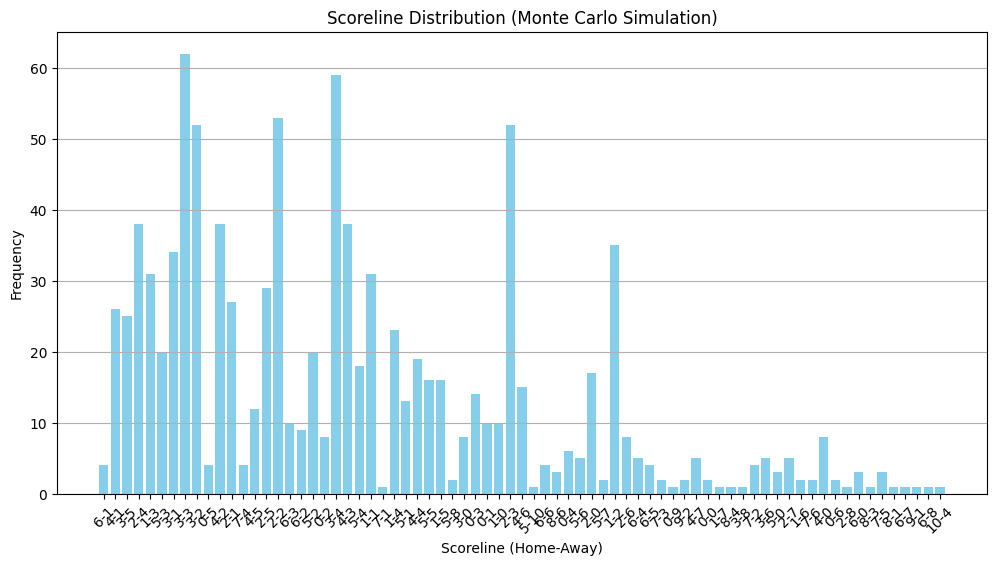

In [57]:
test_single_game_simulation("Manchester City", "Chelsea", 1000)

##### Case 2: Manchester City vs Ipswich Town
Comparing to case 1, examing a stronger team to a weaker team to check the functionality

Most common scoreline: (3, 2) with frequency 69
Average Home Goals: 3.346
Average Away Goals: 2.272
Manchester City won 615 games; Ipswich Town won 223 games; 162 draws
Final scores: | Home : 2007 | Away: 831 |


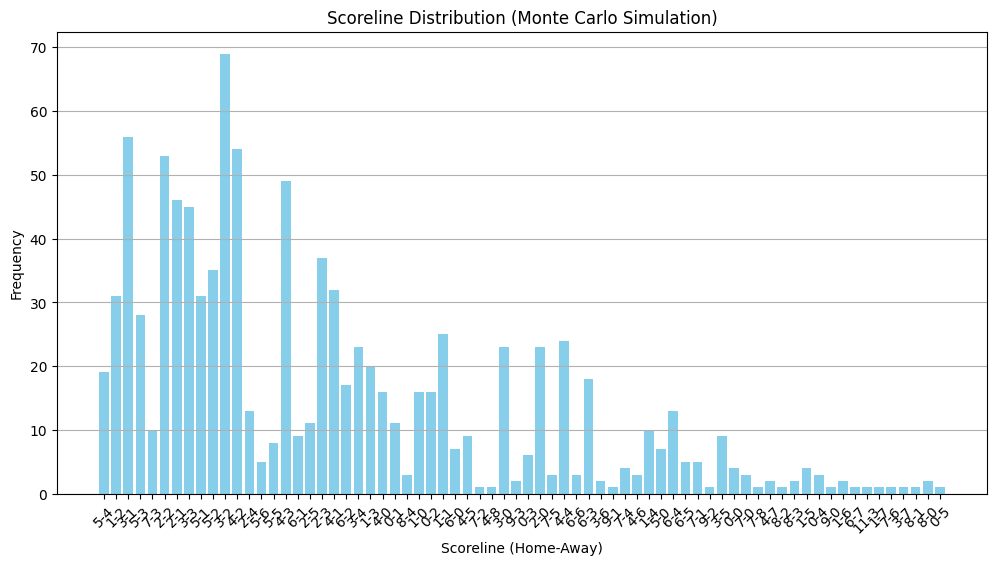

In [58]:
test_single_game_simulation("Manchester City", "Ipswich Town", 1000)

##### Case 3: Chelsea vs Manchester City
Comparing to case 1, examing the effect of being home and away team

Most common scoreline: (3, 3) with frequency 55
Average Home Goals: 3.347
Average Away Goals: 3.096
Chelsea won 455 games; Manchester City won 360 games; 185 draws
Final scores: | Home : 1550 | Away: 1265 |


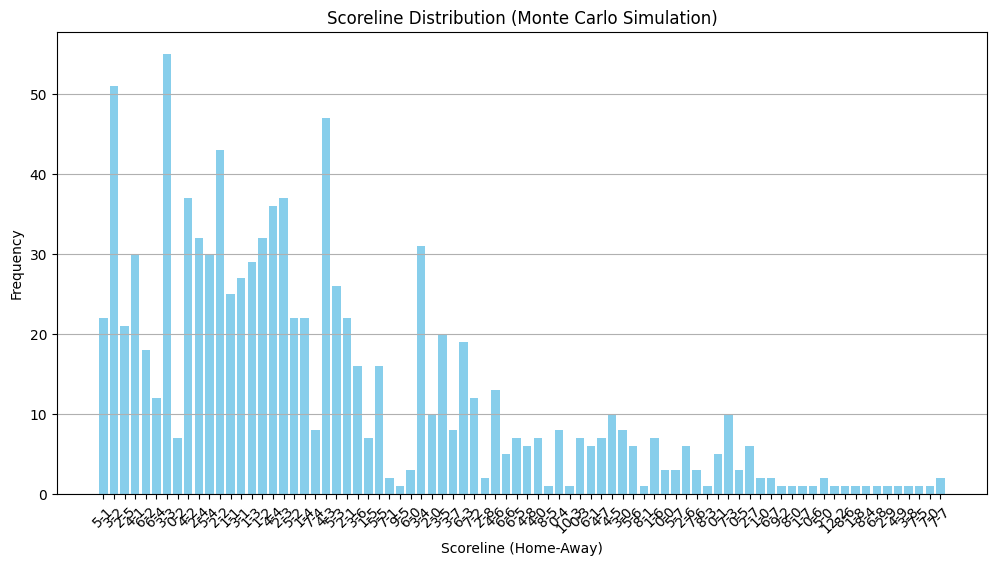

In [59]:
test_single_game_simulation("Chelsea", "Manchester City", 1000)

### Next step: final points prediction
The rules: 
20 teams playing each other home and away across the season, a total of 380 matches.
3 points for a win, 1 point for a draw, 0 point for defeat

Possible presentation data: 
- top 4 teams (qualifying for the next season's UEFA Champions League group stages)
- bottom 3 teams (relegating to the Championship)

In [61]:
def test_one_season():
    """
    Generate the simulation for one season, return the score board
    
    Parameters: no parameter
    
    Returns: a dictionary with team name as key, their score and goals as value
    """
    
    # Initialize season standings
    league_table = {team: {
        "points": 0,
        "goals_scored": 0,
        "goals_conceded": 0,
        "matches_played": 0,
        "wins": 0,
        "draws": 0,
        "losses": 0
    } for team in teams}
    
    # Simulate matches for the entire season
    for home_team in teams:
        for away_team in teams:
            # Don't play against itself
            if home_team != away_team:
                # Simulate the match
                match_results = monte_carlo_match_simulation(home_team, away_team, n_simulations=1000)
                
                # Update team statistics
                home_stats = league_table[home_team]
                away_stats = league_table[away_team]
                
                # Update matches played
                home_stats["matches_played"] += 1
                away_stats["matches_played"] += 1
                
                # Update goals
                home_stats["goals_scored"] += match_results["average_home_goals"]
                home_stats["goals_conceded"] += match_results["average_away_goals"]
                away_stats["goals_scored"] += match_results["average_away_goals"]
                away_stats["goals_conceded"] += match_results["average_home_goals"]
                
                # Update points and match results
                if match_results["home_vic"] > match_results["away_vic"]:
                    home_stats["points"] += 3
                    home_stats["wins"] += 1
                    away_stats["losses"] += 1
                elif match_results["home_vic"] < match_results["away_vic"]:
                    away_stats["points"] += 3
                    away_stats["wins"] += 1
                    home_stats["losses"] += 1
                else:
                    home_stats["points"] += 1
                    away_stats["points"] += 1
                    home_stats["draws"] += 1
                    away_stats["draws"] += 1
    
    # Sort teams by points (and potentially goal difference in future iterations)
    sorted_teams = sorted(
        league_table.items(), 
        key=lambda x: x[1]["points"], 
        reverse=True
    )
    
    # Print league table for visualization
    print("League Table:")
    print("Team".ljust(20), "Points".ljust(10), "Played".ljust(10), "Wins".ljust(10), "Draws".ljust(10), "Losses".ljust(10), "Goals Scored".ljust(15), "Goals Conceded")
    for team, stats in sorted_teams:
        print(
            team.ljust(20), 
            str(stats["points"]).ljust(10), 
            str(stats["matches_played"]).ljust(10), 
            str(stats["wins"]).ljust(10), 
            str(stats["draws"]).ljust(10), 
            str(stats["losses"]).ljust(10), 
            str(round(stats["goals_scored"], 2)).ljust(15), 
            round(stats["goals_conceded"], 2)
        )
    
    return league_table

In [62]:
def visualize_league_season(league_table):
    """
    Create comprehensive visualizations of the league season results.
    
    Parameters:
    league_table (dict): Dictionary containing team statistics from the season simulation
    
    Creates multiple plots to represent league performance:
    1. Points Distribution Bar Chart
    2. Goals Scored vs Goals Conceded Scatter Plot
    3. Team Performance Radar Chart
    """
    # Convert league table to a more plot-friendly format
    teams = list(league_table.keys())
    points = [stats['points'] for stats in league_table.values()]
    goals_scored = [stats['goals_scored'] for stats in league_table.values()]
    goals_conceded = [stats['goals_conceded'] for stats in league_table.values()]
    wins = [stats['wins'] for stats in league_table.values()]
    
    # Create a figure with subplots
    plt.figure(figsize=(15, 10))
    plt.suptitle('League Season Performance Analysis', fontsize=16)
    
    # 1. Points Distribution Bar Chart
    plt.subplot(2, 2, 1)
    plt.bar(teams, points, color='skyblue')
    plt.title('Points Distribution')
    plt.xlabel('Teams')
    plt.ylabel('Total Points')
    plt.xticks(rotation=45, ha='right')
    
    # 2. Goals Scored vs Goals Conceded Scatter Plot
    plt.subplot(2, 2, 2)
    plt.scatter(goals_scored, goals_conceded, c=points, cmap='viridis')
    plt.colorbar(label='Points')
    plt.title('Goals Scored vs Goals Conceded')
    plt.xlabel('Goals Scored')
    plt.ylabel('Goals Conceded')
    
    # Annotate each point with team names
    for i, team in enumerate(teams):
        plt.annotate(team, (goals_scored[i], goals_conceded[i]), 
                     xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 3. Team Performance Radar Chart
    plt.subplot(2, 2, (3, 4), polar=True)
    
    # Normalize the data for radar chart
    def normalize(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))
    
    # Prepare data for radar chart
    performance_metrics = [
        normalize(points),
        normalize(goals_scored),
        normalize(goals_conceded),
        normalize(wins)
    ]
    
    # Number of variables
    categories = ['Points', 'Goals Scored', 'Goals Conceded', 'Wins']
    N = len(categories)
    
    # Create angles for radar chart
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # Plot each team
    plt.title('Comprehensive Team Performance')
    for i, team in enumerate(teams):
        values = [metric[i] for metric in performance_metrics]
        values += values[:1]
        plt.polar(angles, values, marker='o', label=team)
    
    plt.thetagrids(np.degrees(angles[:-1]), categories)
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
    
    # Adjust layout and display
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Showing one season's results

In [63]:
league_results = test_one_season()
visualize_league_season(league_results)

KeyboardInterrupt: 